In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score , GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from joblib import dump, load
import pickle
import joblib
from sklearn.ensemble import GradientBoostingClassifier


In [ ]:
pd.options.display.max_columns = 401
data = pd.read_csv("/playerData.csv", sep=";")
datacp = data.copy()

In [ ]:
datacp

,Column1,player,nationality,position,squad,age,birth_year,value,height,position2,foot,league,games,games_starts,minutes,goals,assists,pens_made,pens_att,cards_yellow,cards_red,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90,xg,npxg,xa,xg_per90,xa_per90,xg_xa_per90,npxg_per90,npxg_xa_per90,minutes_90s,shots_total,shots_on_target,shots_free_kicks,shots_on_target_pct,shots_total_per90,shots_on_target_per90,goals_per_shot,goals_per_shot_on_target,npxg_per_shot,xg_net,npxg_net,passes_completed,passes,passes_pct,passes_total_distance,passes_progressive_distance,passes_completed_short,passes_short,passes_pct_short,passes_completed_medium,passes_medium,passes_pct_medium,passes_completed_long,passes_long,passes_pct_long,xa_net,assisted_shots,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,progressive_passes,passes_live,passes_dead,passes_free_kicks,through_balls,passes_pressure,passes_switches,crosses,corner_kicks,corner_kicks_in,corner_kicks_out,corner_kicks_straight,passes_ground,passes_low,passes_high,passes_left_foot,passes_right_foot,passes_head,throw_ins,passes_other_body,passes_offsides,passes_oob,passes_intercepted,passes_blocked,sca,sca_per90,sca_passes_live,sca_passes_dead,sca_dribbles,sca_shots,sca_fouled,gca,gca_per90,gca_passes_live,gca_passes_dead,gca_dribbles,gca_shots,gca_fouled,gca_og_for,tackles,tackles_won,tackles_def_3rd,tackles_mid_3rd,tackles_att_3rd,dribble_tackles,dribbles_vs,dribble_tackles_pct,dribbled_past,pressures,pressure_regains,pressure_regain_pct,pressures_def_3rd,pressures_mid_3rd,pressures_att_3rd,blocks,blocked_shots,blocked_shots_saves,blocked_passes,interceptions,clearances,errors,touches,touches_def_pen_area,touches_def_3rd,touches_mid_3rd,touches_att_3rd,touches_att_pen_area,touches_live_ball,dribbles_completed,dribbles,dribbles_completed_pct,players_dribbled_past,nutmegs,carries,carry_distance,carry_progressive_distance,pass_targets,passes_received,passes_received_pct,miscontrols,dispossessed,cards_yellow_red,fouls,fouled,offsides,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct,games_gk,games_starts_gk,minutes_gk,goals_against_gk,goals_against_per90_gk,shots_on_target_against,saves,save_pct,wins_gk,draws_gk,losses_gk,clean_sheets,clean_sheets_pct,pens_att_gk,pens_allowed,pens_saved,pens_missed_gk,minutes_90s_gk,free_kick_goals_against_gk,corner_kick_goals_against_gk,own_goals_against_gk,psxg_gk,psnpxg_per_shot_on_target_against,psxg_net_gk,psxg_net_per90_gk,passes_completed_launched_gk,passes_launched_gk,passes_pct_launched_gk,passes_gk,passes_throws_gk,pct_passes_launched_gk,passes_length_avg_gk,goal_kicks,pct_goal_kicks_launched,goal_kick_length_avg,crosses_gk,crosses_stopped_gk,crosses_stopped_pct_gk,def_actions_outside_pen_area_gk,def_actions_outside_pen_area_per90_gk,avg_distance_def_actions_gk,goalsm,assistsm,pens_madem,pens_attm,cards_yellowm,cards_redm,goals_per90m,assists_per90m,goals_assists_per90m,goals_pens_per90m,goals_assists_pens_per90m,xgm,npxgm,xam,xg_per90m,xa_per90m,xg_xa_per90m,npxg_per90m,npxg_xa_per90m,minutes_90sm,shots_totalm,shots_on_targetm,shots_free_kicksm,shots_on_target_pctm,shots_total_per90m,shots_on_target_per90m,goals_per_shotm,goals_per_shot_on_targetm,npxg_per_shotm,xg_netm,npxg_netm,passes_completedm,passesm,passes_pctm,passes_total_distancem,passes_progressive_distancem,passes_completed_shortm,passes_shortm,passes_pct_shortm,passes_completed_mediumm,passes_mediumm,passes_pct_mediumm,passes_completed_longm,passes_longm,passes_pct_longm,xa_netm,assisted_shotsm,passes_into_final_thirdm,passes_into_penalty_aream,crosses_into_penalty_aream,progressive_passesm,passes_livem,passes_deadm,passes_free_kicksm,through_ballsm,passes_pressurem,passes_switchesm,crossesm,corner_kicksm,corner_kicks_inm,corner_kicks_outm,corner_kicks_straightm,passes_groundm,passes_lowm,passes_highm,passes_left_footm,passes_right_footm,passes_headm,throw_insm,passes_other_bodym,passes_

In [ ]:
datacp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Columns: 400 entries, Column1 to Season
dtypes: float64(239), int64(152), object(9)
memory usage: 8.1+ MB


* The data includes information of 2644 football players and 400 different features including their statistics for the 2019 season.

In [ ]:
print(datacp.select_dtypes(include="object").columns.values)

['player' 'nationality' 'position' 'squad' 'position2' 'foot' 'league'
 'Attendance' 'Season']


* We are learning about the features in the object structure.
* By using field information, we exclude features (name, nationality, birthday, WinCL, etc.) that will be ineffective in determining positions from the data.

In [ ]:
datacp = datacp.drop(columns=["Column1","player","nationality","WinCL","CL","position",
                    "CLBestScorer","squad","birth_year","value","league","Season","Attendance"])

* we observe the missing data and discard it because the missing data is not so much that it affects the success of the model.

In [ ]:
datacp.isnull().sum()

age           0
height        0
position2     0
foot         16
games         0
             ..
Pts/G         0
xG            0
xGA           0
xGDiff        0
xGDiff/90     0
Length: 387, dtype: int64

In [ ]:
datacp.isnull().sum().max()

16

In [ ]:
datacp = datacp.dropna()

* the target variable(position 2) consists of 12 different classes containing the positions of the players, but we are correcting them as the 2 positions are shown in 4 different ways.

In [ ]:
datacp.position2.unique()

array(['Defender - Right-Back', 'Forward - Right Winger',
       'Midfielder - Central Midfield', 'Defender - Left-Back',
       'Defender - Centre-Back', 'Midfielder - Defensive Midfield',
       'Forward - Centre-Forward', 'Forward - Left Winger', 'Goalkeeper',
       'Midfielder - Attacking Midfield', 'Midfielder - Left Midfield',
       'Midfielder - Right Midfield', 'Central Midfield',
       'Forward - Second Striker'], dtype=object)

In [ ]:
datacp = datacp.replace({
    'Central Midfield': 'Midfielder - Central Midfield',
    'Forward - Second Striker' : 'Forward - Centre-Forward' 
    })

In [ ]:
datacp.position2.nunique()

12

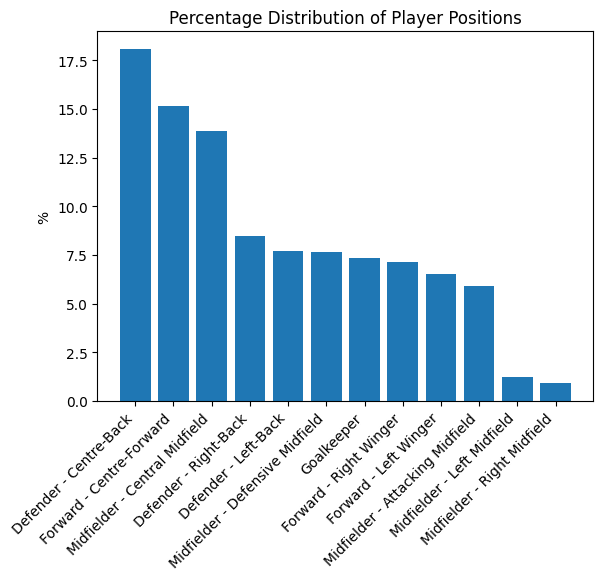

In [ ]:
pst_bar = pd.DataFrame(datacp['position2'].value_counts(normalize=True)*100).reset_index()
plt.bar(pst_bar["index"], pst_bar.position2)
plt.ylabel("%")
plt.title("Percentage Distribution of Player Positions")
plt.xticks(rotation=45, ha='right');

* The reason for having a higher percentage in the central defense position is that in a match, two different players usually play in this position at the same time.

* When we look at the distribution of positions, we see that there are limited numbers of players in the right wing and left wing positions. This is because in modern football, there are generally no players who play directly in these positions, and they remain as positions where wingers and fullbacks have secondary roles.

Text(0.5, 1.0, 'The distribution of playing times (in minutes)')

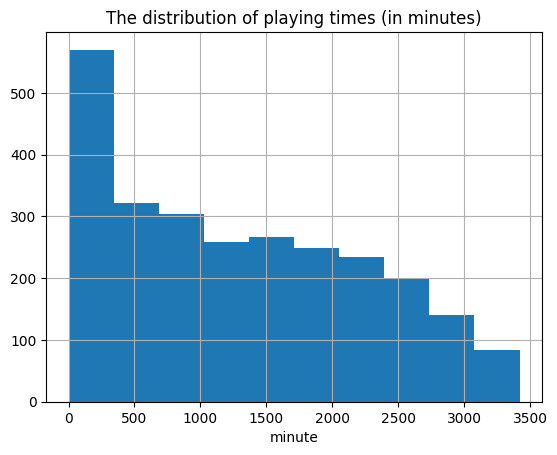

In [ ]:
datacp["minutes"].hist()
plt.xlabel("minute")
plt.title("The distribution of playing times (in minutes)")


* In this graph, there is a distribution of the playing times of footballers during one season.
* Assuming that a footballer needs to have played at least one full match (90 minutes) in order to provide us with informative statistics about their position, we remove from our dataset the footballers who played less than 90 minutes in one season.

In [ ]:
datacp = datacp.reset_index()

In [ ]:
datacp = datacp.drop(datacp[datacp.minutes < 90].index, axis=0)

In [ ]:
datacp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2390 entries, 0 to 2627
Columns: 388 entries, index to xGDiff/90
dtypes: float64(238), int64(148), object(2)
memory usage: 7.1+ MB


* When we remove the players who played under 90 minutes and the lines with missing data from our data, we have the data of 2390 players.

In [ ]:
datacp.corr()

,index,age,height,games,games_starts,minutes,goals,assists,pens_made,pens_att,cards_yellow,cards_red,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90,xg,npxg,xa,xg_per90,xa_per90,xg_xa_per90,npxg_per90,npxg_xa_per90,minutes_90s,shots_total,shots_on_target,shots_free_kicks,shots_on_target_pct,shots_total_per90,shots_on_target_per90,goals_per_shot,goals_per_shot_on_target,npxg_per_shot,xg_net,npxg_net,passes_completed,passes,passes_pct,passes_total_distance,passes_progressive_distance,passes_completed_short,passes_short,passes_pct_short,passes_completed_medium,passes_medium,passes_pct_medium,passes_completed_long,passes_long,passes_pct_long,xa_net,assisted_shots,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,progressive_passes,passes_live,passes_dead,passes_free_kicks,through_balls,passes_pressure,passes_switches,crosses,corner_kicks,corner_kicks_in,corner_kicks_out,corner_kicks_straight,passes_ground,passes_low,passes_high,passes_left_foot,passes_right_foot,passes_head,throw_ins,passes_other_body,passes_offsides,passes_oob,passes_intercepted,passes_blocked,sca,sca_per90,sca_passes_live,sca_passes_dead,sca_dribbles,sca_shots,sca_fouled,gca,gca_per90,gca_passes_live,gca_passes_dead,gca_dribbles,gca_shots,gca_fouled,gca_og_for,tackles,tackles_won,tackles_def_3rd,tackles_mid_3rd,tackles_att_3rd,dribble_tackles,dribbles_vs,dribble_tackles_pct,dribbled_past,pressures,pressure_regains,pressure_regain_pct,pressures_def_3rd,pressures_mid_3rd,pressures_att_3rd,blocks,blocked_shots,blocked_shots_saves,blocked_passes,interceptions,clearances,errors,touches,touches_def_pen_area,touches_def_3rd,touches_mid_3rd,touches_att_3rd,touches_att_pen_area,touches_live_ball,dribbles_completed,dribbles,dribbles_completed_pct,players_dribbled_past,nutmegs,carries,carry_distance,carry_progressive_distance,pass_targets,passes_received,passes_received_pct,miscontrols,dispossessed,cards_yellow_red,fouls,fouled,offsides,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct,games_gk,games_starts_gk,minutes_gk,goals_against_gk,goals_against_per90_gk,shots_on_target_against,saves,save_pct,wins_gk,draws_gk,losses_gk,clean_sheets,clean_sheets_pct,pens_att_gk,pens_allowed,pens_saved,pens_missed_gk,minutes_90s_gk,free_kick_goals_against_gk,corner_kick_goals_against_gk,own_goals_against_gk,psxg_gk,psnpxg_per_shot_on_target_against,psxg_net_gk,psxg_net_per90_gk,passes_completed_launched_gk,passes_launched_gk,passes_pct_launched_gk,passes_gk,passes_throws_gk,pct_passes_launched_gk,passes_length_avg_gk,goal_kicks,pct_goal_kicks_launched,goal_kick_length_avg,crosses_gk,crosses_stopped_gk,crosses_stopped_pct_gk,def_actions_outside_pen_area_gk,def_actions_outside_pen_area_per90_gk,avg_distance_def_actions_gk,goalsm,assistsm,pens_madem,pens_attm,cards_yellowm,cards_redm,goals_per90m,assists_per90m,goals_assists_per90m,goals_pens_per90m,goals_assists_pens_per90m,xgm,npxgm,xam,xg_per90m,xa_per90m,xg_xa_per90m,npxg_per90m,npxg_xa_per90m,minutes_90sm,shots_totalm,shots_on_targetm,shots_free_kicksm,shots_on_target_pctm,shots_total_per90m,shots_on_target_per90m,goals_per_shotm,goals_per_shot_on_targetm,npxg_per_shotm,xg_netm,npxg_netm,passes_completedm,passesm,passes_pctm,passes_total_distancem,passes_progressive_distancem,passes_completed_shortm,passes_shortm,passes_pct_shortm,passes_completed_mediumm,passes_mediumm,passes_pct_mediumm,passes_completed_longm,passes_longm,passes_pct_longm,xa_netm,assisted_shotsm,passes_into_final_thirdm,passes_into_penalty_aream,crosses_into_penalty_aream,progressive_passesm,passes_livem,passes_deadm,passes_free_kicksm,through_ballsm,passes_pressurem,passes_switchesm,crossesm,corner_kicksm,corner_kicks_inm,corner_kicks_outm,corner_kicks_straightm,passes_groundm,passes_lowm,passes_highm,passes_left_footm,passes_right_footm,passes_headm,throw_insm,passes_other_bodym,passes_offsidesm,passes_oobm,passes_interceptedm,passes_blockedm,scam,sca_per90m,s

* To solve the multicollinearity problem, I discard features with correlation higher than 0.98.

In [ ]:
# function for highly correlated features
def correlation(data, threshold=None):
    col_corr = set()
    corr_mat = data.corr()
    for i in range(len(corr_mat.columns)):
        for j in range(i):
            if (abs(corr_mat.iloc[i,j]) > threshold):
                colname = corr_mat.columns[i]
                col_corr.add(colname)
    return col_corr

In [ ]:
multi = correlation(datacp,threshold=0.98)
len(multi)

51

In [ ]:
datacp = datacp.drop(columns=multi,axis=1)

In [ ]:
len(datacp.columns)

337

* While encoding, we did the encoding manually instead of using the label encoder, because when we create the web interface with streamlit, we want to be sure which position our prediction value is pointing to.

In [ ]:
position2 = []
for i in datacp["position2"]:
  if i == "Goalkeeper":
    position2.append(0)
  elif i == "Defender - Centre-Back" :
    position2.append(1)
  elif i == "Defender - Right-Back":
    position2.append(2)
  elif i == "Defender - Left-Back":
    position2.append(3)
  elif i == "Midfielder - Left Midfield":
    position2.append(4)
  elif i == "Midfielder - Right Midfield":
    position2.append(5)
  elif i == "Midfielder - Defensive Midfield":
    position2.append(6)
  elif i == "Midfielder - Central Midfield":
    position2.append(8)
  elif i == "Forward - Left Winger":
    position2.append(7)
  elif i == "Forward - Centre-Forward":
    position2.append(9)
  elif i == "Midfielder - Attacking Midfield":
    position2.append(10)
  else :
    position2.append(11)

In [ ]:
datacp['position2'] = position2

In [ ]:
datacp.head()

,index,age,height,position2,foot,games,games_starts,goals,assists,pens_made,pens_att,cards_yellow,cards_red,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,xg,npxg,xa,xg_per90,xa_per90,xg_xa_per90,npxg_per90,shots_total,shots_on_target,shots_free_kicks,shots_on_target_pct,shots_total_per90,shots_on_target_per90,goals_per_shot,goals_per_shot_on_target,npxg_per_shot,xg_net,passes_completed,passes_pct,passes_total_distance,passes_progressive_distance,passes_completed_short,passes_pct_short,passes_completed_medium,passes_pct_medium,passes_completed_long,passes_long,passes_pct_long,xa_net,assisted_shots,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,progressive_passes,passes_dead,passes_free_kicks,through_balls,passes_pressure,passes_switches,crosses,corner_kicks,corner_kicks_in,corner_kicks_out,corner_kicks_straight,passes_low,passes_high,passes_left_foot,passes_right_foot,passes_head,throw_ins,passes_other_body,passes_offsides,passes_oob,passes_intercepted,passes_blocked,sca,sca_per90,sca_passes_live,sca_passes_dead,sca_dribbles,sca_shots,sca_fouled,gca,gca_per90,gca_passes_live,gca_passes_dead,gca_dribbles,gca_shots,gca_fouled,gca_og_for,tackles,tackles_won,tackles_def_3rd,tackles_mid_3rd,tackles_att_3rd,dribble_tackles,dribbles_vs,dribble_tackles_pct,dribbled_past,pressures,pressure_regains,pressure_regain_pct,pressures_def_3rd,pressures_mid_3rd,pressures_att_3rd,blocks,blocked_shots,blocked_shots_saves,blocked_passes,interceptions,clearances,errors,touches_def_pen_area,touches_def_3rd,touches_mid_3rd,touches_att_3rd,touches_att_pen_area,dribbles_completed,dribbles,dribbles_completed_pct,nutmegs,carries,carry_distance,pass_targets,passes_received_pct,miscontrols,dispossessed,cards_yellow_red,fouls,fouled,offsides,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct,games_gk,goals_against_gk,goals_against_per90_gk,save_pct,wins_gk,draws_gk,losses_gk,clean_sheets,clean_sheets_pct,pens_att_gk,pens_saved,pens_missed_gk,free_kick_goals_against_gk,corner_kick_goals_against_gk,own_goals_against_gk,psnpxg_per_shot_on_target_against,psxg_net_gk,psxg_net_per90_gk,passes_completed_launched_gk,passes_pct_launched_gk,passes_gk,passes_throws_gk,pct_passes_launched_gk,pct_goal_kicks_launched,crosses_stopped_gk,crosses_stopped_pct_gk,def_actions_outside_pen_area_gk,def_actions_outside_pen_area_per90_gk,avg_distance_def_actions_gk,pens_madem,pens_attm,cards_yellowm,cards_redm,goals_per90m,assists_per90m,goals_assists_per90m,goals_pens_per90m,xg_per90m,xa_per90m,xg_xa_per90m,npxg_per90m,npxg_xa_per90m,minutes_90sm,shots_totalm,shots_on_targetm,shots_free_kicksm,shots_on_target_pctm,shots_total_per90m,shots_on_target_per90m,goals_per_shotm,goals_per_shot_on_targetm,npxg_per_shotm,xg_netm,npxg_netm,passes_completedm,passesm,passes_pctm,passes_total_distancem,passes_progressive_distancem,passes_completed_shortm,passes_completed_mediumm,passes_completed_longm,passes_longm,passes_pct_longm,xa_netm,assisted_shotsm,passes_into_final_thirdm,passes_into_penalty_aream,crosses_into_penalty_aream,progressive_passesm,passes_livem,passes_deadm,passes_free_kicksm,through_ballsm,passes_pressurem,passes_switchesm,crossesm,corner_kicksm,corner_kicks_inm,corner_kicks_outm,corner_kicks_straightm,passes_groundm,passes_lowm,passes_highm,passes_left_footm,passes_right_footm,passes_headm,throw_insm,passes_other_bodym,passes_offsidesm,passes_oobm,passes_interceptedm,passes_blockedm,sca_per90m,sca_passes_livem,sca_passes_deadm,sca_dribblesm,sca_shotsm,sca_fouledm,gca_per90m,gca_passes_livem,gca_passes_deadm,gca_dribblesm,gca_shotsm,gca_fouledm,gca_og_form,tacklesm,tackles_wonm,tackles_def_3rdm,tackles_mid_3rdm,tackles_att_3rdm,dribble_tacklesm,dribbles_vsm,dribble_tackles_pctm,dribbled_pastm,pressuresm,pressure_regainsm,pressure_regain_pctm,pressures_def_3rdm,pressures_mid_3rdm,pressures_att_3rdm,blocksm,blocked_shotsm,blocked_shots_savesm,blocked_passesm,interceptionsm,clearancesm,errorsm,to

* We applied get_dummies to our only property (foot) that is in the object structure.

In [ ]:
datacp = pd.get_dummies(datacp, columns=["foot"], drop_first=True)

In [ ]:
y = datacp["position2"]
X = datacp.drop(columns = ["position2","index"], axis=1)

In [ ]:
feature_name = list(X.columns)

In [ ]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.22, random_state=42, stratify=y)

In [ ]:
sc = StandardScaler()
X = sc.fit_transform(X)
X_test = sc.transform(X_test)

In [ ]:
xgb = GradientBoostingClassifier()
xgb.fit(X,y)

GradientBoostingClassifier()

In [ ]:
xgb.score(X_test,y_test)

0.7585551330798479

In [ ]:
y_pred = xgb.predict(X_test)
metrics.f1_score(y_test,y_pred, average='weighted')

0.7466875164611304

* Although we achieved 76% accuracy and 75% f1_score, was it really necessary to give all features to the model?
* Using feature_importance, which shows the importance of features in the model's performance based on their weights, I created a dataframe by classifying features according to their importance levels.

In [ ]:
importance = list(xgb.feature_importances_)

In [ ]:
feature_importance = pd.DataFrame(data=importance, index=feature_name, columns=["feature_importance"])

In [ ]:
feature_importance.sort_values(["feature_importance"], ascending=True)

,feature_importance
crosses_stopped_gkm,0.00
pct_passes_launched_gk,0.00
pct_goal_kicks_launched,0.00
crosses_stopped_gk,0.00
crosses_stopped_pct_gk,0.00
...,...
passes_left_footm,0.08
touches_mid_3rdm,0.10
throw_insm,0.10
passes_received_pct,0.11


* As can be seen, there are features with weights close to zero that we unnecessarily gave to our model.
* So, how many of the 336 features do we need to discard?
We will create a loop to identify the features that are effective in our model's success by tracking our accuracy and f1 scores.

In [ ]:
# The list len_throw_feature keeps track of how many features are dropped in each loop.
len_throw_feature = []
# xgb_accuracy and xgb_f1_score will record the accuracy and f1 score generated by the removed features in each loop.
xgb_accuracy = []
xgb_f1_score = []

for i in range(50,335,3):
  #At the beginning of each loop, the features to be dropped are determined.
  unimportent = list(feature_importance.sort_values(["feature_importance"], ascending=True)[0:int(i+1)].index)

  #After identifying the features and target variables in the data, we discard the features we have identified.
  y = datacp["position2"]
  X = datacp.drop(columns = ["position2","index"], axis=1)
  X = X.drop(columns=unimportent,axis=1)

  X, X_test, y, y_test = train_test_split(X, y, test_size=0.22, random_state=42 shuffle=True, stratify=y)
 
  X = sc.fit_transform(X)
  X_test = sc.transform(X_test)

  xgb = GradientBoostingClassifier()
  xgb.fit(X,y)

  len_throw_feature.append(i)
  xgb_accuracy.append(xgb.score(X_test,y_test))
  y_pred = xgb.predict(X_test)
  xgb_f1_score.append(metrics.f1_score(y_test,y_pred, average='weighted'))
  



* We analyze the results we obtained from the loop we created by transferring them to a line graph.
* As can be seen, when we remove the lowest weighted 260 features from our data set, there is no change in accuracy and f1_score.
* We can analyze our model and evaluate it only based on 75 features.

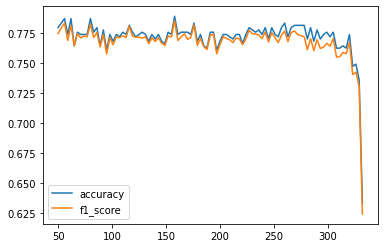

In [ ]:
grafik=pd.DataFrame({'accuracy':xgb_accuracy,'f1_score':xgb_f1_score},index=len_throw_feature)
grafik.plot(kind='line')
plt.show()

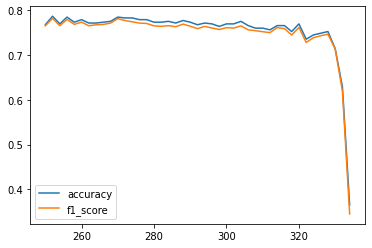

In [ ]:
grafik=pd.DataFrame({'accuracy':xgb_accuracy,'f1_score':xgb_f1_score},index=len_throw_feature)
grafik.plot(kind='line')
plt.show()

* We make a list of features that we will discard from our data.

In [ ]:
throw_feature = list(feature_importance.sort_values(["feature_importance"], ascending=True).head(261).index)

* We take a look at our 5 most influential features in the success of our model.

In [ ]:
feature_importance.sort_values(["feature_importance"], ascending=True).tail(5)

,feature_importance
dribblesm,0.02
pressures_def_3rdm,0.02
passes_into_final_thirdm,0.02
passes_deadm,0.03
pressures_mid_3rdm,0.03
touches_def_3rdm,0.04
passes_left_footm,0.08
touches_mid_3rdm,0.10
throw_insm,0.10
passes_received_pct,0.11


In [ ]:
position_name1 = {0:"Goalkeeper",1:"Defender - Centre-Back",2:"Defender - Right-Back",3:"Defender - Left-Back",
                 4:"Midfielder - Left Midfield",5:"Midfielder - Right Midfield",6:"Midfielder - Defensive Midfield",
                 8:"Midfielder - Central Midfield",7:"Forward - Left Winger",9:"Forward - Centre-Forward",
                 10:"Midfielder - Attacking Midfield",11:"Forward - Right Winger"}

In [ ]:
def get_position(x):
  val = position_name1.get(x)
  return val


Let's look at the effectiveness of key features on positions.

**clearancesm**

In [ ]:
position_clearancesm = datacp.groupby("position2").agg({"clearancesm":"mean"}).reset_index().sort_values(['clearancesm'],ascending=[False])

In [ ]:
position_clearancesm.position2  = position_clearancesm.position2.apply(get_position)

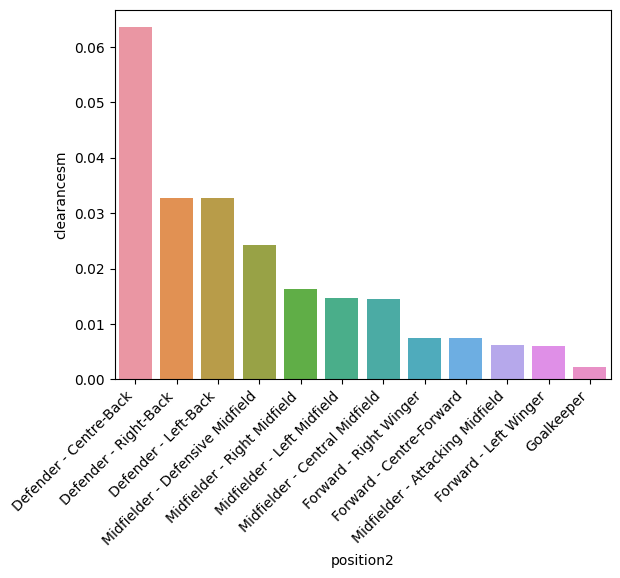

In [ ]:
sns.barplot(position_clearancesm, y="clearancesm",x="position2")
plt.xticks(rotation=45, ha='right');

* The average of clearances in central defenders is significantly higher than other positions.
* In defensive positions, the average of this statistic is generally higher.


In [ ]:
position_passes = datacp.groupby("position2").agg({"passes_received_pct":"mean"}).reset_index().sort_values(['passes_received_pct'],ascending=[False])

In [ ]:
position_passes.position2  = position_passes.position2.apply(get_position)

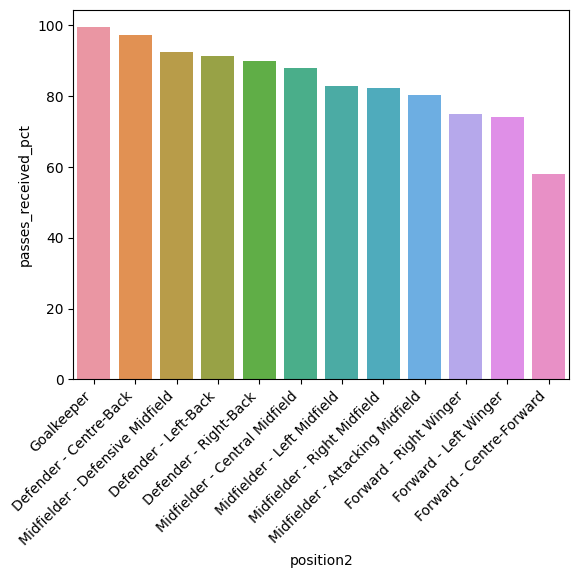

In [ ]:
sns.barplot(position_passes, y="passes_received_pct",x="position2")
plt.xticks(rotation=45, ha='right');

* The average of passing accuracy decreases from defense to attack.

In [ ]:
position_throw = datacp.groupby("position2").agg({"throw_insm":"mean"}).reset_index().sort_values(['throw_insm'],ascending=[False])

In [ ]:
position_throw.position2  = position_throw.position2.apply(get_position)

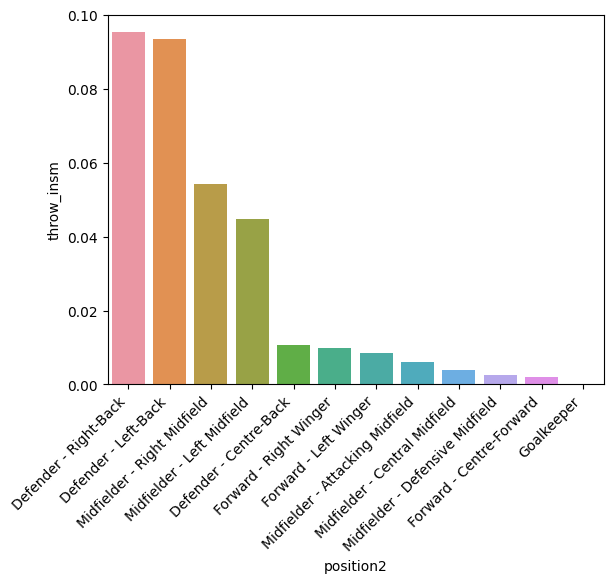

In [ ]:
sns.barplot(position_throw, y="throw_insm",x="position2")
plt.xticks(rotation=45, ha='right');

* Throw-in duty is undertaken by the players in the winger and full-back positions.

In [ ]:
position_touch = datacp.groupby("position2").agg({"touches_mid_3rdm":"mean"}).reset_index().sort_values(['touches_mid_3rdm'],ascending=[False])

In [ ]:
position_touch.position2  = position_touch.position2.apply(get_position)

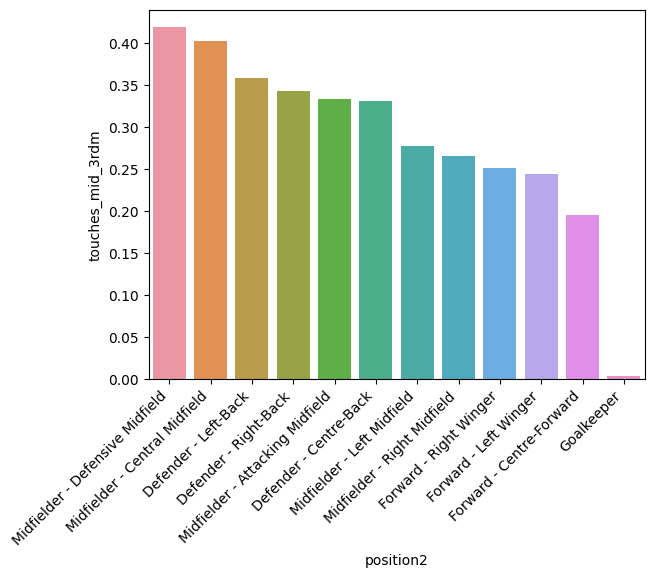

In [ ]:
sns.barplot(position_touch, y="touches_mid_3rdm",x="position2")
plt.xticks(rotation=45, ha='right');

In [ ]:
y = datacp["position2"]
X = datacp.drop(columns = ["position2","index"], axis=1)

In [ ]:
X = X.drop(columns=throw_feature,axis=1)

In [ ]:
X, X_test, y, y_test = train_test_split(X, y, random_state=42, test_size=0.22, stratify=y)

In [ ]:
sc = StandardScaler()
X = sc.fit_transform(X)
X_test = sc.transform(X_test)

In [ ]:
xgb = GradientBoostingClassifier()

In [ ]:
acc_xgboost = cross_val_score(xgb, X, y, cv=4, scoring='accuracy')
print(acc_xgboost)
print(acc_xgboost.mean())


[0.76609442 0.75751073 0.74892704 0.7639485 ]
0.7591201716738197


* We can achieve the same success score and f1_score with only 75 features.

In [ ]:
xgb = GradientBoostingClassifier()

In [ ]:
xgb.fit(X,y)

GradientBoostingClassifier()

In [ ]:
xgb.score(X_test,y_test)

0.7661596958174905

In [ ]:
y_pred = xgb.predict(X_test)
metrics.f1_score(y_test,y_pred, average='weighted')

0.7508892896078193

In [ ]:
position_name = ["Goalkeeper","Defender - Centre-Back","Defender - Right-Back","Defender - Left-Back",
                 "Midfielder - Left Midfield","Midfielder - Right Midfield","Midfielder - Defensive Midfield",
                 "Midfielder - Central Midfield","Forward - Left Winger","Forward - Centre-Forward",
                 "Midfielder - Attacking Midfield","Forward - Right Winger"]

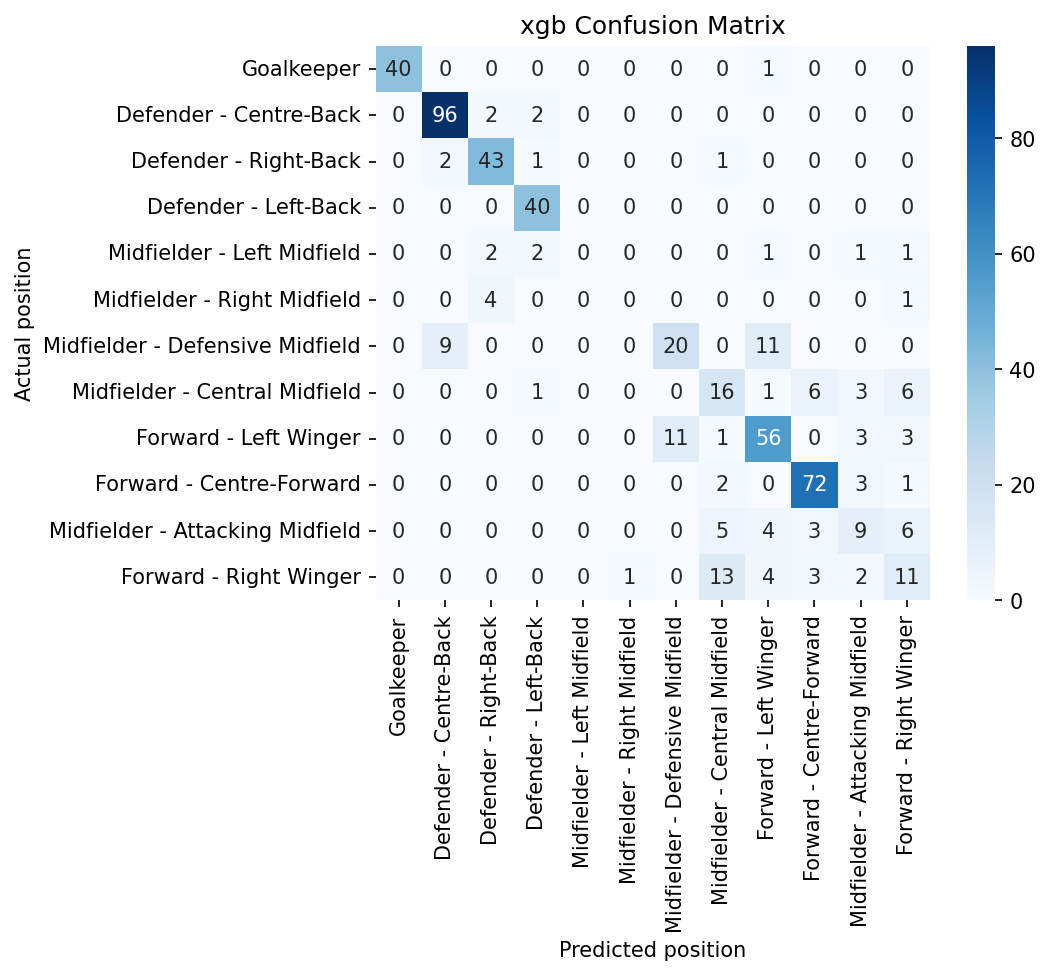

In [ ]:
xgb_confusion = confusion_matrix(y_test, y_pred)

plt.figure(dpi=150)
plt.title('xgb Confusion Matrix')
sns.heatmap(xgb_confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=position_name,
           yticklabels=position_name)
plt.xlabel('Predicted position')
plt.ylabel('Actual position');

* Our model achieved a high f1_score in the goalkeeper, defender and forward positions with a clear distribution of duties, while achieving a lower f1 score in the midfield positions that play two-way (defensive and offensive) on the field.